In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.utils import shuffle as sklearnShuffle
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, GlobalAveragePooling2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dropout
from keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
from numpy.random import shuffle
from keras.models import Model
from random import randint

# Visualizations will be shown in the notebook.
%matplotlib inline


Using TensorFlow backend.


In [2]:
samples = []

with open('./data/driving_log.csv', 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            if row[3] == 'steering': 
                print(row)
            else:
                img_center = row[0].split("\\")[-1]
                img_center = img_center.split("/")[-1]
                steering_center = float(row[3])
                samples.append([img_center, steering_center])

samples = np.array(samples)
print(samples.shape)

['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
(8036, 2)


center_2016_12_01_13_30_48_287.jpg
Shape of image: (160, 320, 3)


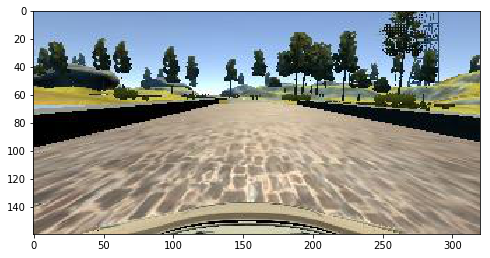

In [3]:
ex_name = samples[0,0]
print(ex_name)
ex_image = imread("./data/IMG/" + ex_name)
plt.figure(figsize=(8,8))
plt.imshow(ex_image)
print('Shape of image: {}'.format(ex_image.shape))

In [4]:
def translation(image, tx):
    M = np.float32([[1,0,tx],[0,1,0]])
    dst = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return dst

Shape of image: (160, 320, 3)
dtype of image: uint8
0 255


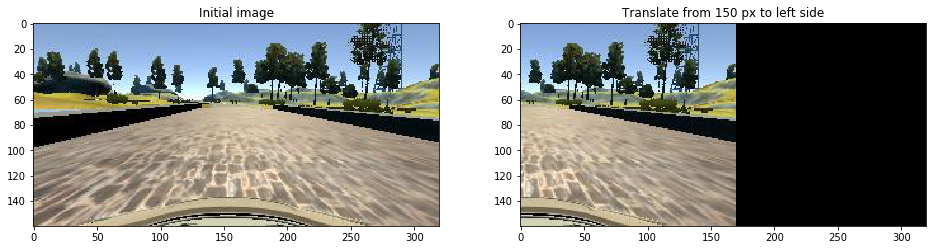

In [5]:
imagetr = translation(ex_image, -150)
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title('Initial image')
plt.imshow(ex_image)
plt.subplot(122)
plt.title('Translate from 150 px to left side')
plt.imshow(imagetr)
print('Shape of image: {}'.format(imagetr.shape))
print('dtype of image: {}'.format(imagetr.dtype))
print(imagetr.min(), imagetr.max())

Shape of image: (160, 320, 3)
dtype of image: uint8
0 255


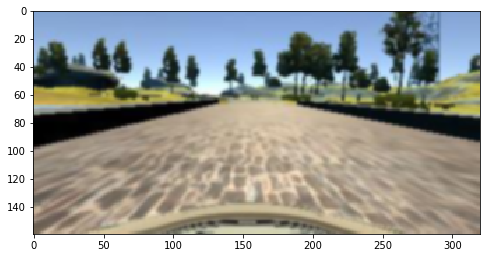

In [6]:
ex_image = cv2.GaussianBlur(ex_image, (5,5), 0)
plt.figure(figsize=(8,8))
plt.imshow(ex_image)
print('Shape of image: {}'.format(ex_image.shape))
print('dtype of image: {}'.format(ex_image.dtype))
print(ex_image.min(), ex_image.max())

Shape of image: (160, 320, 3)
dtype of image: uint8
0 249


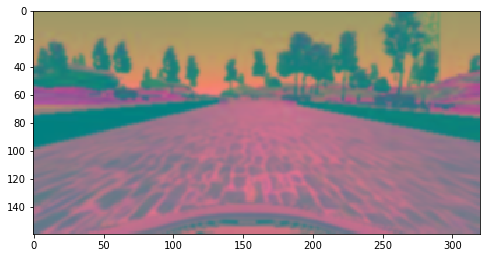

In [7]:
ex_image = cv2.cvtColor(ex_image, cv2.COLOR_BGR2YUV)
plt.figure(figsize=(8,8))
plt.imshow(ex_image)
print('Shape of image: {}'.format(ex_image.shape))
print('dtype of image: {}'.format(ex_image.dtype))
print(ex_image.min(), ex_image.max(),)

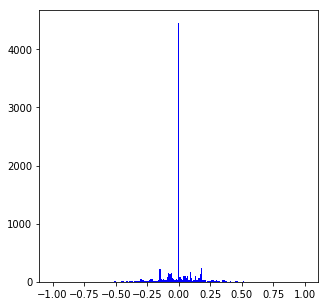

Samples labeling - mean: 0.0040696440648332515, std: 0.12883205581793244, min: -0.9426954, max: 1.0


In [8]:
bins = [(i - 0.5)/100 for i in range(-100, 102)]
plt.figure(figsize=(5, 5))
plt.hist(samples[:,1].astype(float), bins, facecolor = 'b', label = 'Training Label')
plt.show()
print('Samples labeling - mean: {}, std: {}, min: {}, max: {}'.format(samples[:,1].astype(float).mean(),
                                                                      samples[:,1].astype(float).std(),
                                                                      samples[:,1].astype(float).min(),
                                                                      samples[:,1].astype(float).max()))

In [9]:
correction = 0.005 # this is a parameter to tune
input_shape = (160,320,3) # Image shape

In [10]:
index = np.argmax(samples[:,1])
print(samples[index,0])

center_2016_12_01_13_38_42_894.jpg


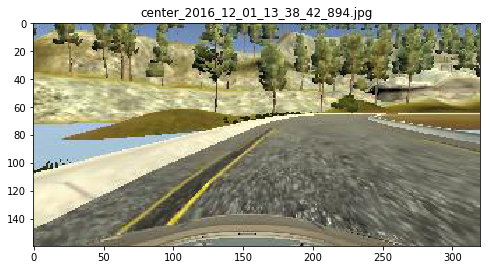

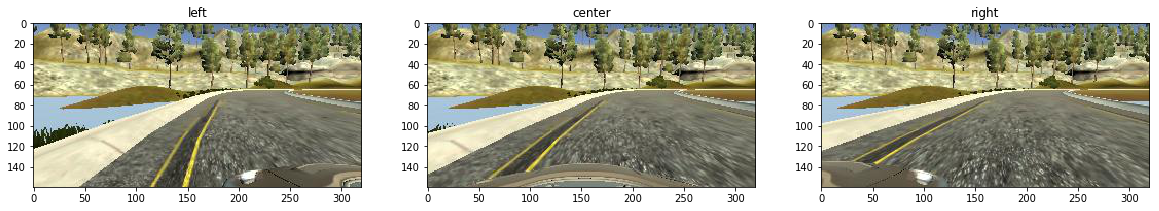

In [11]:
ex2_image = imread("./data/IMG/center_2016_12_01_13_38_42_894.jpg")
plt.figure(figsize=(8,8))
plt.title('center_2016_12_01_13_38_42_894.jpg')
plt.imshow(ex2_image)

plt.figure(figsize=(20,8))
plt.subplot(131)
plt.title('left')
plt.imshow(imread('./data/IMG/left_2016_12_01_13_38_42_894.jpg'))
plt.subplot(132)
plt.title('center')
plt.imshow(imread('./data/IMG/center_2016_12_01_13_38_42_894.jpg'))
plt.subplot(133)
plt.title('right')
plt.imshow(imread('./data/IMG/right_2016_12_01_13_38_42_894.jpg'))

Shape of image: (160, 320, 3)
dtype of image: uint8
0 255


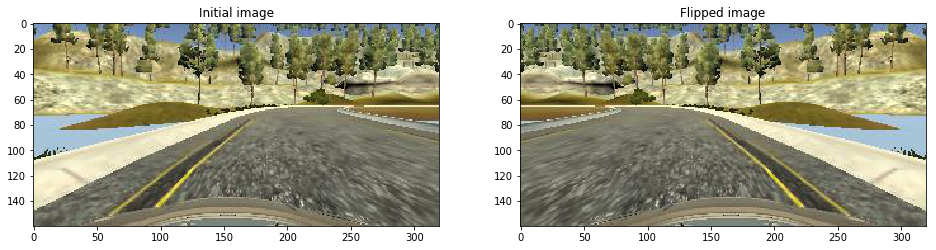

In [12]:
flipped_image = np.fliplr(imread('./data/IMG/center_2016_12_01_13_38_42_894.jpg'))
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title('Initial image')
plt.imshow(imread('./data/IMG/center_2016_12_01_13_38_42_894.jpg'))
plt.subplot(122)
plt.title('Flipped image')
plt.imshow(flipped_image)
print('Shape of image: {}'.format(imagetr.shape))
print('dtype of image: {}'.format(imagetr.dtype))
print(imagetr.min(), imagetr.max())

In [13]:
samples = []

with open('./data/driving_log.csv', 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            if row[3] == 'steering': 
                print(row)
            else:
                img_center = row[0].split("\\")[-1]
                img_center = img_center.split("/")[-1]
                img_left = row[1].split("\\")[-1]
                img_left = img_left.split("/")[-1]
                img_right = row[2].split("\\")[-1]
                img_right = img_right.split("/")[-1]
            
                img_center_flipped = 'flipped_' + img_center
                img_left_flipped = 'flipped_' + img_left
                img_right_flipped = 'flipped_' + img_right
            
                steering_center = float(row[3])
                steering_left = steering_center + correction
                steering_right = steering_center - correction
                if steering_left > 1.:
                    steering_left = 1.
                if steering_right < -1.:
                    steering_right = -1.
            
                steering_center_flipped = -steering_center
                steering_left_flipped = -steering_left
                steering_right_flipped = -steering_right
            
                samples.append([img_center, steering_center])
                samples.append([img_left, steering_left])
                samples.append([img_right, steering_right])
                samples.append([img_center_flipped, steering_center_flipped])
                samples.append([img_left_flipped, steering_left_flipped])
                samples.append([img_right_flipped, steering_right_flipped])

samples = np.array(samples)
print(samples.shape)

['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
(48216, 2)


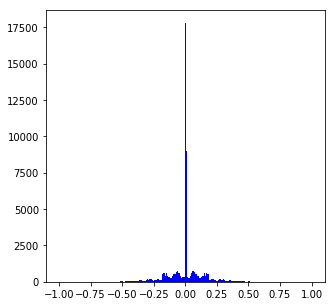

Samples labeling - mean: -5.497464475055088e-20, std: 0.1289577279639452, min: -1.0, max: 1.0


In [14]:
plt.figure(figsize=(5, 5))
plt.hist(samples[:,1].astype(float), bins, facecolor = 'b', label = 'Training Label')
plt.show()
print('Samples labeling - mean: {}, std: {}, min: {}, max: {}'.format(samples[:,1].astype(float).mean(),
                                                                      samples[:,1].astype(float).std(),
                                                                      samples[:,1].astype(float).min(),
                                                                      samples[:,1].astype(float).max()))

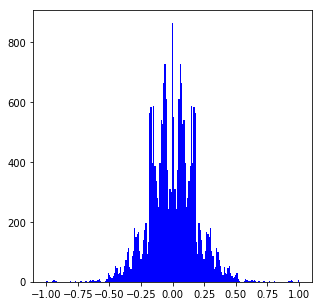

shape of sample set: (22800, 2)
Samples labeling - mean: 4.674623261579606e-19, std: 0.1874825242765741, min: -1.0, max: 1.0


In [15]:
shuffle(samples)
i1, i2, i3 = 0, 0, 0
new_samples = []
for sample in samples:
    if float(sample[1]) == 0.:
        if i1 < 250:
            i1 += 1
            new_samples.append(sample)
            
    elif float(sample[1]) == correction:
        if i2 < 250:
            i2 += 1
            new_samples.append(sample)
        
    elif float(sample[1]) == -correction:
        if i3 < 250:
            i3 += 1
            new_samples.append(sample)
            
    else:
        new_samples.append(sample)
            
samples = np.array(new_samples)
        
plt.figure(figsize=(5, 5))
plt.hist(samples[:,1].astype(float), bins, facecolor = 'b', label = 'Training Label')
plt.show()
print('shape of sample set: {}'.format(samples.shape))
print('Samples labeling - mean: {}, std: {}, min: {}, max: {}'.format(samples[:,1].astype(float).mean(),
                                                                      samples[:,1].astype(float).std(),
                                                                      samples[:,1].astype(float).min(),
                                                                      samples[:,1].astype(float).max()))    
        

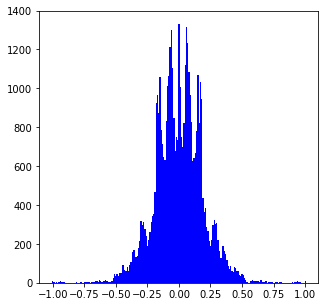

shape of sample set: (45600, 2)
Samples labeling - mean: 3.4298245614036957e-06, std: 0.18788274241848918, min: -1.0, max: 1.0


In [16]:
new_samples = []
for sample in samples:
    random = randint(-150,150)
    translated_img = str(random) + '_translated_' + sample[0]
    translated_steering = float(sample[1]) + random / 6000
    if translated_steering > 1.:
        translated_steering = 1.
    if translated_steering < -1.:
        translated_steering = -1.
    new_samples.append(sample)
    new_samples.append([translated_img, translated_steering])
    
samples = np.array(new_samples)

plt.figure(figsize=(5, 5))
plt.hist(samples[:,1].astype(float), bins, facecolor = 'b', label = 'Training Label')
plt.show()
print('shape of sample set: {}'.format(samples.shape))
print('Samples labeling - mean: {}, std: {}, min: {}, max: {}'.format(samples[:,1].astype(float).mean(),
                                                                      samples[:,1].astype(float).std(),
                                                                      samples[:,1].astype(float).min(),
                                                                      samples[:,1].astype(float).max()))    

shape of train sample set: (41040, 2)
shape of validation sample set: (4560, 2)


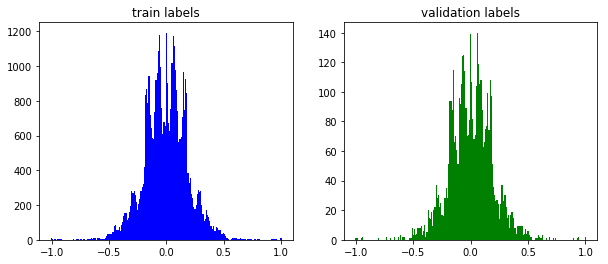

Train labeling - mean: -0.00024494759485867455, std: 0.18758092004105226, min: -1.0, max: 1.0
Validation labeling - mean: 0.002238826599342105, std: 0.1905630675001632, min: -0.9966, max: 1.0


In [17]:
train_samples, validation_samples = train_test_split(samples, test_size=0.1, random_state=0)
print('shape of train sample set: {}'.format(train_samples.shape))
print('shape of validation sample set: {}'.format(validation_samples.shape))
fig, (train, validation) = plt.subplots(ncols=2, figsize=(10, 4))
train.hist(train_samples[:,1].astype(float), bins, color = 'b')
train.set_title('train labels')
validation.hist(validation_samples[:,1].astype(float), bins, color = 'g')
validation.set_title('validation labels')
plt.show()

print('Train labeling - mean: {}, std: {}, min: {}, max: {}'.format(train_samples[:,1].astype(float).mean(),
                                                                      train_samples[:,1].astype(float).std(),
                                                                      train_samples[:,1].astype(float).min(),
                                                                      train_samples[:,1].astype(float).max()))
print('Validation labeling - mean: {}, std: {}, min: {}, max: {}'.format(validation_samples[:,1].astype(float).mean(),
                                                                      validation_samples[:,1].astype(float).std(),
                                                                      validation_samples[:,1].astype(float).min(),
                                                                      validation_samples[:,1].astype(float).max()))

In [18]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = batch_sample[0]
                if 'flipped' in name and 'translated' in name:
                    rand = float(name.split('_')[0])
                    name = name.replace(name.split('_')[0]+'_translated_flipped_', '')
                    image = imread("./data/IMG/" + name)
                    image = np.fliplr(image)
                    image = translation(image, rand)
                elif 'flipped' in name:
                    name = name.replace('flipped_', '')
                    image = imread("./data/IMG/" + name)
                    image = np.fliplr(image)
                elif 'translated' in name:
                    rand = float(name.split('_')[0])
                    name = name.replace(name.split('_')[0]+'_translated_', '')
                    image = imread("./data/IMG/" + name)
                    image = translation(image, rand)
                else:
                    image = imread("./data/IMG/" + name)
                angle = float(batch_sample[1])
                images.append(image)
                angles.append(angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearnShuffle(X_train, y_train)

In [19]:
model = Sequential()
model.add(Cropping2D(cropping=((60,20), (0,0)), input_shape=input_shape))
model.add(Lambda(lambda x: (x / 255.0) - 0.5))
model.add(Convolution2D(5,5,5, activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(10,5,5, activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(20,5,5, activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(30,3,3, activation="relu"))
model.add(Convolution2D(30,3,3, activation="relu"))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(50, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1))


In [20]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 80, 320, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 80, 320, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 76, 316, 5)    380         lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 38, 158, 5)    0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [21]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [22]:
model.compile(loss='mse', optimizer='adam')
history = model.fit_generator(train_generator, samples_per_epoch= len(train_samples),
                              validation_data=validation_generator, nb_val_samples=len(validation_samples), 
                              nb_epoch=7, verbose = 2)

Epoch 1/7
99s - loss: 0.0192 - val_loss: 0.0164
Epoch 2/7
97s - loss: 0.0152 - val_loss: 0.0150
Epoch 3/7
97s - loss: 0.0145 - val_loss: 0.0147
Epoch 4/7
97s - loss: 0.0141 - val_loss: 0.0147
Epoch 5/7
97s - loss: 0.0136 - val_loss: 0.0149
Epoch 6/7
97s - loss: 0.0132 - val_loss: 0.0136
Epoch 7/7
97s - loss: 0.0128 - val_loss: 0.0134


dict_keys(['val_loss', 'loss'])


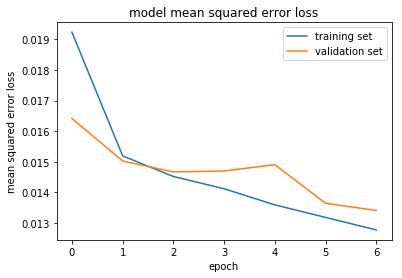

In [23]:
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [24]:
model.evaluate_generator(generator=validation_generator, val_samples=len(validation_samples))

0.013523655941938622

In [25]:
def generator_predict(samples, batch_size=128):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            for batch_sample in batch_samples:
                name = batch_sample[0]
               
                if 'flipped' in name and 'translated' in name:
                    rand = float(name.split('_')[0])
                    name = name.replace(name.split('_')[0]+'_translated_flipped_', '')
                    image = imread("./data/IMG/" + name)
                    image = np.fliplr(image)
                    image = translation(image, rand)
                elif 'flipped' in name:
                    name = name.replace('flipped_', '')
                    image = imread("./data/IMG/" + name)
                    image = np.fliplr(image)
                elif 'translated' in name:
                    rand = float(name.split('_')[0])
                    name = name.replace(name.split('_')[0]+'_translated_', '')
                    image = imread("./data/IMG/" + name)
                    image = translation(image, rand)
                else:
                    image = imread("./data/IMG/" + name)
                
                images.append(image)
                
            images = np.array(images)
            yield images
            

In [26]:
val_pred = model.predict_generator(generator_predict(validation_samples), val_samples=len(validation_samples))

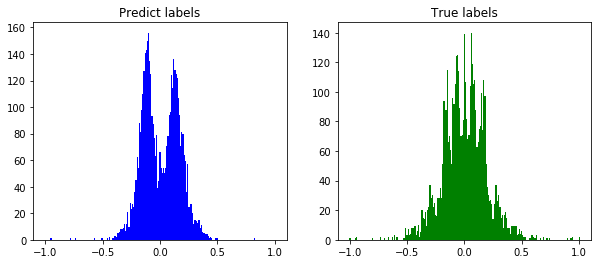

Shape of prediction: (4560, 1)
Shape of Initial labeling: (4560,)
Prediction - mean: 0.007028651423752308, std: 0.1607336550951004, min: -0.9475950598716736, max: 1.1416641473770142
Initial labeling - mean: 0.0022388265993421065, std: 0.1905630675001632, min: -0.9966, max: 1.0


In [27]:
fig, (predict, truth) = plt.subplots(ncols=2, figsize=(10, 4))
predict.hist(val_pred, bins, color = 'b')
predict.set_title('Predict labels')
truth.hist(validation_samples[:,1].astype(float), bins, color = 'g')
truth.set_title('True labels')
plt.show()

print('Shape of prediction: {}'.format(val_pred.shape))
print('Shape of Initial labeling: {}'.format(validation_samples[:,1].astype(float).shape))
print('Prediction - mean: {}, std: {}, min: {}, max: {}'.format(val_pred.mean(),val_pred.std(),
                                                             val_pred.min(),val_pred.max()))
print('Initial labeling - mean: {}, std: {}, min: {}, max: {}'.format(validation_samples[:,1].astype(float).mean()
                                                                      ,validation_samples[:,1].astype(float).std(),
                                                                      validation_samples[:,1].astype(float).min(),
                                                                      validation_samples[:,1].astype(float).max()))

In [28]:
output_layer = model.layers[-1]
print(output_layer.name)
print(output_layer.get_config())
print(output_layer.get_weights())

dense_4
{'b_regularizer': None, 'activity_regularizer': None, 'name': 'dense_4', 'bias': True, 'trainable': True, 'W_constraint': None, 'init': 'glorot_uniform', 'activation': 'linear', 'W_regularizer': None, 'input_dim': 10, 'output_dim': 1, 'b_constraint': None}
[array([[ 0.37781218],
       [ 0.13597959],
       [ 0.15138315],
       [ 0.17079963],
       [-0.15750626],
       [ 0.2977708 ],
       [-0.16945249],
       [ 0.08219161],
       [ 0.38445249],
       [-0.25333673]], dtype=float32), array([-0.00218997], dtype=float32)]


In [29]:
model.save('model.h5')
print('model saved')

model saved
